 # <center><b>Claude Monet Paintings and Generative Deep Learning</b></center>

# INTRODUCTION
The aim of this work is to build and train a generative adversarial network (GAN) using the Monet Paintings dataset available at Kaggle. GANs consists of two or more neural networks. There is a generator network that creates images and a discriminator network to train the generator. The discriminator classifies the images as real or fake. These are called adversarial networks because they are competing. The generator is working to maximize the chances that a mistake is made by the discriminator, and the discriminator is trying to minimize the chances of making a mistake. The task is to generate 7,000 to 10,000 images that are in the style of Monet’s paintings and fool the discriminator. 

**Citation:**

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

**GitHub Repository:**



# LIBRARIES

In [ ]:
import os
import random
import shutil
import numpy as np
import itertools
import torch
from torch import nn
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple

# IMPORT DATA

In [ ]:
# Input data files are available in the read-only "../input/" directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

## Dataset Directories

In [ ]:
monet_dir = "/kaggle/input/gan-getting-started/monet_jpg/"
photo_dir = "/kaggle/input/gan-getting-started/photo_jpg/"

## Make a Subset of Photos
There are 7028 phots and 300 images of Monet paintings. To ensure the datasets are balanced and the models can be trained in a timely manner a random subset of 300 photos will be used. 

### Code to Clear Subset Directory
If the notebook has already been run the subset folder needs to be cleared before selecting the subset or photos will continue to be added to it. If this is the first run of the notebook the following chunk of code can be ignored. 

In [ ]:
# Check if the directory exists
if os.path.exists(photo_subset_dir):
    # Delete all files in the directory
    shutil.rmtree(photo_subset_dir)
    print(f"All photos in {photo_subset_dir} have been deleted.")
    os.makedirs(photo_subset_dir)
    print(f"{photo_subset_dir} directory has been recreated.")
else:
    print(f"Directory {photo_subset_dir} does not exist.")

### Create Subset of Photos

In [ ]:
photo_subset_dir = "/kaggle/working/photo_subset/"

# Create a directory for the subset 
os.makedirs(photo_subset_dir, exist_ok=True)
all_photos = os.listdir(photo_dir)

# Randomly select 300 photos
subset_photos = random.sample(all_photos, 300)

# Copy selected photos to the subset directory
for photo in subset_photos:
    shutil.copy(os.path.join(photo_dir, photo), photo_subset_dir)

print("Subset of 300 photos created.")

# IMAGE PROCESSING

# Create PyTorch Class for Datasets
For loading and processing images from the directory to comply with PyTorch's data loading pipeline.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root: str, class_idx: int, max_size: int = -1, transform=None) -> None:
        """
        Initialize the dataset.        
        root: image directory.
        class_idx: image labels.
        max_size: maximum number of images to load from the directory.
        transform: transformations to apply to the images.
        """
        self.paths = [os.path.join(root, img) for img in os.listdir(root)]
        random.shuffle(self.paths)
        self.paths = self.paths[:max_size] if max_size > 0 else self.paths
        self.transform = transform
        self.class_idx = class_idx

    def load_image(self, index: int) -> Image.Image:
        """
        Load an image from the dataset at the specified index.
        return: PIL Image
        """
        try:
            image = Image.open(self.paths[index])
            return image
        except Exception as e:
            print(f"Error loading image {self.paths[index]}: {e}")
            return None

    def __len__(self) -> int:
        """
        Return the total number of images in the dataset.
        """
        return len(self.paths) # Total number of samples
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieve an image and its label.
        return: Tuple(transformed image tensor, class label).
        """
        img = self.load_image(index)
        if img is None:
            return None   
        if self.transform:
            img = self.transform(img)
        return img, self.class_idx    


## Image Transformation
Images will be resized to 256 by 256. Then they will be randomly cropped to produce some variability. Pixel values will be normalized to have a mean of 0.5 and a standard deviation of 0.5 for each color channel.

In [ ]:
# Data Transformations
data_transform = transforms.Compose([
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),
    transforms.RandomCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Create Datasets (use photo subset directory for photo dataset)
monet_dataset = CustomImageDataset(root=monet_dir, class_idx=1, transform=data_transform)
photo_dataset = CustomImageDataset(root=photo_subset_dir, class_idx=0, transform=data_transform)

# Data Loaders
batch_size = 24
num_workers = 2  

monet_dl = DataLoader(dataset=monet_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)
photo_dl = DataLoader(dataset=photo_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)

# DATA EXPLORATION

In [ ]:
print(f"There are {len(monet_dataset)} images of Monet's Paintings")
print(f"There are {len(photo_dataset)} images of photos")

In [ ]:
monets = next(iter(monet_dl))
photos = next(iter(photo_dl))

In [ ]:
# Inspect the first batch of images from each dataloader
monet_images, _ = monets  # Separate images and labels
photo_images, _ = photos

# Check the image dimensions 
print("Dimensions of Monet image:", monet_images[0].shape)
print("Dimensions of photo:", photo_images[0].shape)

In [ ]:
monets_imshow = []
for monet in monets:
    if monet.dim() == 4:  
        for img in monet: 
            if img.dim() == 3:  # Ensure image is a tensor 
                img = img.permute(1, 2, 0)  # Tensor [C, H, W] to [H, W, C]
                img = img.numpy() 
                img = img * 0.5 + 0.5  # Undo data normalization
                monets_imshow.append(img)
            else:
                print(f"Skipping img with unexpected shape {img.shape}")
    else:
        print(f"Skipping tensor with shape {monet.shape}")
        
        
photos_imshow = []
for photo in photos:
    if photo.dim() == 4:  
        for img in photo:  
            if img.dim() == 3:  # Ensure image is a tensor 
                img = img.permute(1, 2, 0)  # Tensor [C, H, W] to [H, W, C]
                img = img.numpy() 
                img = img * 0.5 + 0.5  # Undo data normalization
                photos_imshow.append(img)
            else:
                print(f"Skipping img with unexpected shape {img.shape}")
    else:
        print(f"Skipping tensor with shape {photo.shape}")       

## Display Examples of Monet Paintings and Photos

In [ ]:
def display_images(images, title, n_images=4, figsize=(15, 5)):
    fig = plt.figure(figsize=figsize) 

    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        img = images[i]
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0)  
            img = img.numpy()  
        plt.imshow(img)
        plt.axis('off')

    fig.suptitle(title, fontsize=16)
    plt.show()

display_images(monets_imshow, 'Monets')
display_images(photos_imshow, 'Photos')

# GAN MODELS

## Generator Function and Architecture

### Purpose of Generator
The generator analyzes the images, identifying the key attributes and modifying some of the attributes by adding noise to them. Its goal is to produce images that are indistinguishable from the real paintings. 

### Generator Architecture and Why it is Suitable
The network is made up of fully connected layers, including batch normalization layers to help stabilize the model, followed by Upsample layers to increase the spatial resolution, then Conv2d layers to extract image features. The Conv2d layers also add padding ensuring the output has the same dimensions as the input. LeakyReLU activations are used because they allow for negative inputs and are therefore more versatile and appropriate for distinguishing between images. Lastly a Tanh activation output layer scales the pixel values between -1 and 1. Since images are normalized to the range -1 and 1, the Tanh activation ensures that the pixel values of the generated images are within the expected range. See comments in code for details about specific layers. 




In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder, Downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Bottleneck 
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1), 
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Decoder, Upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=1, padding=1),  
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), 
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  
            nn.Tanh()
        )

    def forward(self, img):
        enc_out = self.encoder(img)
        bottleneck = self.bottleneck(enc_out)
        dec_out = self.decoder(bottleneck)
        return dec_out


## Discriminator Function and Architecture

### Purpose of Discriminator
Takes the modified images from the generator as input and classifies it as real or fake. 

### Discriminator Architecture and Why it is Suitable
The core block of the discriminator uses a similar architecture as the generator. There is batch normalization, Conv2d Layers and, LeakyReLU activations are used for the same reasons as they were in the generator.  Dropout layers were also added to the discriminator to help prevent overfitting to specific patterns in the data, which improves stability. The discriminator uses sigmoid activation as the output to produce a probability as its purpose is to perform binary classification.  


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalization=True, stride=2):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        # Apply spectral normalization to improve stability
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(discriminator_block(64, 128)[0]),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(discriminator_block(128, 256)[0]),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(discriminator_block(256, 512, stride=1)[0]),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, 1, 4, padding=1))
        )
        
    def forward(self, img):
        return self.model(img)

def spectral_norm(module):
    """Apply spectral normalization to a module"""
    return nn.utils.spectral_norm(module)

## Training the GAN
The networks are trained until the discriminator can no longer distinguish between the real and synthesized images. This will be done by adjusting the model’s weights with the discriminator loss function (loss_D) penalizing the discriminator for misclassifying images, and the generator loss function (loss_G) penalizing the generator if the discriminator can detect that the images are fake. The parameters of both networks are updated using an Adam optimizer. 

### Function to Show a Subset of Images as They are Being Generated

In [ ]:
def show_generated_img(fake_images, epoch, batch):
    """
    Display images during training.
    
    fake_images: Tensor of generated images
    epoch: Current epoch number
    batch: Current batch number
    """
    # Undo normalization 
    fake_images = (fake_images * 0.5) + 0.5
    img_grid = vutils.make_grid(fake_images[:6], padding=2, normalize=True)
    
    # Plot
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(img_grid.cpu(), (1, 2, 0)))
    plt.title(f"Epoch {epoch}, Batch {batch}")
    plt.axis('off')
    plt.show()

## Training Parameters
The first iteration of the training will use a learning rate of 0.001, beta1 set to 0.5 and beta2 set to 0.999. Beta1 sets the decay rate for the moving average of the gradient and beta2 controls the decay rate for the moving average of the squared gradient.

In [ ]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Mean Squared Error (MSE) Loss function
#criterion = nn.MSELoss()

# Binary cross-entropy loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers 
optimizer_g1 = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_d1 = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))

### VGG Network
The VGGLoss function uses a pre-trained VGG network to compare images based on their features rather than just pixel values. The VGG network was trained on ImageNet for classification tasks. This will be used for calculating preceptual loss helping to generate sharper Monet-style images.

In [ ]:
class VGGLoss(nn.Module):
    def __init__(self, device):
        super(VGGLoss, self).__init__()
        #vgg = models.vgg19(pretrained=True).features[:29].to(device)
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:29].to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]
        
    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

### Monet's Paintings 1st Training

In [ ]:
# Training loop Monet Paintings Take 1
num_epochs = 200
display_interval = 200  # For printing generated images

# Lists to hold training history
discriminator_losses_m1 = []
generator_losses_m1 = []

criterion_gan = nn.MSELoss()  # For adversarial loss
criterion_cycle = nn.L1Loss()  # For content preservation
vgg_loss = VGGLoss(device)  # For perceptual loss

for epoch in range(num_epochs):
    for i, (real_photos, _) in enumerate(photo_dl):  # Load real photos
        batch_size = real_photos.size(0)
        real_photos = real_photos.to(device)
        real_monet = next(iter(monet_dl))[0].to(device)

        # Generate fake Monet-style images from real photos
        fake_monet = generator(real_photos) 

        # Train discriminator
        discriminator.zero_grad()
        output_real = discriminator(real_monet)
        output_fake = discriminator(fake_monet.detach())

        # Ensure labels match discriminator output
        real_labels = torch.ones_like(output_real, device=device)
        fake_labels = torch.zeros_like(output_fake, device=device)

        loss_real = criterion_gan(output_real, real_labels)
        loss_fake = criterion_gan(output_fake, fake_labels)
        loss_D = (loss_real + loss_fake) / 2
        discriminator_losses_m1.append(loss_D.item())

        loss_D.backward()
        optimizer_d1.step()

        # Train generator
        generator.zero_grad()
        fake_labels = torch.ones_like(output_fake, device=device)  # Trick discriminator
        output = discriminator(fake_monet)
        loss_gan = criterion_gan(output, fake_labels)
        
        # Content loss to help preserve structure
        loss_content = criterion_cycle(fake_monet, real_photos) * 10.0

         # Perceptual loss to help preserve details using VGG net
        loss_perceptual = vgg_loss(fake_monet, real_photos) * 5.0

        loss_G = loss_gan + loss_content + loss_perceptual
        generator_losses_m1.append(loss_G.item())
        loss_G.backward()
        optimizer_g1.step()

        if i % display_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(photo_dl)}] \
                  Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")
            show_generated_img(fake_monet, epoch, i)

In [ ]:
# Plotting Discriminator and Generator Losses
plt.figure(figsize=(10, 5))

# Plot Discriminator Loss
plt.plot(discriminator_losses_m1, label='Discriminator Loss', color='red')

# Plot Generator Loss
plt.plot(generator_losses_m1, label='Generator Loss', color='blue')
plt.title("Discriminator and Generator Losses During 1st Monet Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc="upper right")

## Results From Training 
The discriminator loss measures how well the discriminator is distinguishing between real and generated samples. High discriminator loss means the discriminator is not differentiating between real and fake images very well. The generator loss measures how well the generator is fooling the discriminator. A low generator loss indicates the generator is successfully creating images that the discriminator cannot easily differentiate from real ones. The discriminator loss did decrease rapidly for the first few epochs then gradually decreased after that. Based on visual inspection the image quality did improve dramatically by the end of training. 

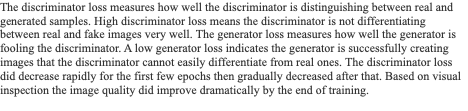
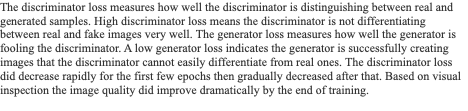
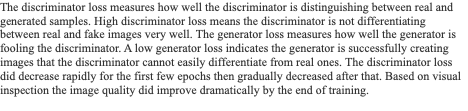
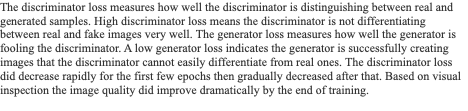

# COMPETITION SUBMISSION

In [ ]:
import zipfile
from PIL import Image
from tqdm import tqdm
import io

photo_dir = "/kaggle/input/gan-getting-started/photo_jpg/"
test_dataset = CustomImageDataset(root=photo_dir, class_idx=0, transform=data_transform)
# Make sure batch size and num_works are consistent with what the network was trained on
photo_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=False, num_workers=2)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output zip file path
zip_filename = '/kaggle/working/images.zip'

def generate_monet_images(photo_dataloader, generator, num_images=7000):
    """
    Generate Monet-style images from photos and save directly to a zip file.
    
    Args:
        photo_dataloader: DataLoader containing photo images
        generator: Trained generator model
        num_images: Number of images to generate (default: 7000)
    """
    generator.eval()  # Set generator to evaluation mode
    
    count = 0
    with zipfile.ZipFile(zip_filename, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        with torch.no_grad():  # Disable gradient calculation for inference
            for batch in tqdm(photo_dataloader, desc="Generating images"):
                # Move input to device
                real_photos = batch[0].to(device)
                
                # Generate fake Monet images
                fake_monets = generator(real_photos)
                
                # Process each image in the batch
                for fake_monet in fake_monets:
                    if count >= num_images:
                        break
                    
                    # Denormalize from [-1, 1] to [0, 1]
                    fake_monet = (fake_monet * 0.5 + 0.5).cpu()
                    
                    # Convert to numpy array in uint8 format 
                    img_array = (fake_monet.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                    
                    # Create PIL image
                    img = Image.fromarray(img_array)
                    
                    # Save image to zip file 
                    img_byte_arr = io.BytesIO()
                    img.save(img_byte_arr, format='JPEG', quality=95)
                    zipf.writestr(f'monet_{count:04d}.jpg', img_byte_arr.getvalue())
                    
                    count += 1
                    if count >= num_images:
                        break
    
    print(f"Generated and zipped {count} Monet-style images.")
    return count

# Generate 7,000 Monet-style images
num_generated = generate_monet_images(photo_dataloader, generator, num_images=7000)
print(f"Submission file created: {zip_filename}")
print(f"Total images zipped: {num_generated}")

## Generated Images 

In [ ]:
def show_generated_images(images, num_images=5):
    # Denormalize images
    images = (images * 0.5) + 0.5
    images = images.clamp(0, 1)

    num_images = min(num_images, images.size(0))
    plt.figure(figsize=(3 * num_images, 3))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(transforms.ToPILImage()(images[i].cpu()))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Sample batch of photos
photos = next(iter(photo_dataloader))[0].to(device)

with torch.no_grad():
    fake_monet = generator(photos)

show_generated_images(fake_monet, num_images=6)